In [1]:
from scraper import Scraper as BoxscoreScraper

In [2]:
scraper = BoxscoreScraper(year=2023)

In [3]:
scraper.get_season_boxscores()

Beginning scraping for 2023-2024 season



  0%|          | 0/2 [00:00<?, ?it/s]

Scraping boxscores for Week 1
Succesfully scraped boxscores for Week 1

Scraping boxscores for Week 2
Succesfully scraped boxscores for Week 2



In [1]:
from filing import Filing

import pandas as pd
class Cleaning:

    def __init__(self, **kwargs):
        """
        This class will contain the functionality to combine, clean, wrangle, and partition all the boxscores
        """

        self.year: int = int(kwargs.get('year', 2023))
        self.season: str = f'{self.year}-{self.year+1}'

        # Initialize filing object
        self.filing = Filing(self.season)

        # ppr_coeff = 0.5 if kwargs.get('hppr', False) else 1.0      
        self.raw: pd.DataFrame = (self.filing.combined()
                                  # .assign(fpts=lambda df: 0.04*df.pass_yds + 4.0*df.pass_td - 1.0*df.pass_int + 0.1*df.rush_yds + 6.0*df.rush_td + ppr_coeff*df.rec + 0.1*df.rec_yds + 6.0*df.rec_td - 1.0*df.fumbles_lost)
                                 )

    def load_team_boxscores(self, team: str) -> pd.DataFrame:
        return self.filing.load_boxscores()[team]

    def load_team_snapcounts(self, team: str) -> pd.DataFrame:
        return self.filing.load_snapcounts()[team]

    def load_team_adv_stats(self, team: str, category: str) -> pd.DataFrame:
        return self.filing.load_advanced_stats()[category][team]



In [2]:
cleaning = Cleaning(year=2023)

In [3]:
df = cleaning.raw

In [4]:
df['game-id'] = df[['team', 'opp', 'week']].apply(lambda row: f'{row.iloc[0]}-{row.iloc[1]}-week{row.iloc[2]}' if row.iloc[0] > row.iloc[1] else f'{row.iloc[1]}-{row.iloc[0]}-week{row.iloc[2]}', axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             311 non-null    object 
 1   team             311 non-null    object 
 2   pass_cmp         311 non-null    int64  
 3   pass_att         311 non-null    int64  
 4   pass_yds         311 non-null    int64  
 5   pass_td          311 non-null    int64  
 6   pass_int         311 non-null    int64  
 7   pass_sacked      311 non-null    int64  
 8   pass_sacked_yds  311 non-null    int64  
 9   pass_long        311 non-null    int64  
 10  pass_rating      311 non-null    float64
 11  rush_att         311 non-null    int64  
 12  rush_yds         311 non-null    int64  
 13  rush_td          311 non-null    int64  
 14  rush_long        311 non-null    int64  
 15  targets          311 non-null    int64  
 16  rec              311 non-null    int64  
 17  rec_yds         

In [6]:
nyg_boxscores = cleaning.load_team_boxscores('NYG')
nyg_snapcounts = cleaning.load_team_snapcounts('NYG')

sf_boxscores = cleaning.load_team_boxscores('SF')
sf_snapcounts = cleaning.load_team_snapcounts('SF')

In [7]:
nyg_receiving = cleaning.load_team_adv_stats('NYG', 'receiving')
# nyg_snapcounts = cleaning.load_team_snapcounts('NYG')

# sf_boxscores = cleaning.load_team_boxscores('SF')
# sf_snapcounts = cleaning.load_team_snapcounts('SF')
sf_receiving = cleaning.load_team_adv_stats('SF', 'receiving')

In [8]:
def receiving_stats(team: str, **kwargs):
    rec = cleaning.load_team_adv_stats(team, 'receiving')

    stats = ['targets', 'rec', 'rec_yds', 'rec_adot'] + kwargs.get('stats', [])

    if kwargs.get('raw', False):
        return (rec
                [['name', 'pos'] + stats]
                .sort_values(stats, ascending=False)
                .reset_index(drop=True)
               )

    return (rec
            .groupby('name')
            [stats]
            .agg(['mean'])
            .sort_values([('targets', 'mean'), ('rec_adot', 'mean')], ascending=False)
           )

In [9]:
receiving_stats('SF', raw=True)

,name,pos,targets,rec,rec_yds,rec_adot
0,Deebo Samuel,WR,9,6,63,6.1
1,Brandon Aiyuk,WR,8,8,129,13.6
2,Deebo Samuel,WR,7,5,55,10.4
3,Brandon Aiyuk,WR,6,3,43,13.5
4,George Kittle,TE,6,3,19,5.2
5,Christian McCaffrey,RB,5,3,17,2.4
6,George Kittle,TE,3,3,30,5.7
7,Christian McCaffrey,RB,3,3,19,0.3
8,Jauan Jennings,WR,3,2,51,23.7
9,Jauan Jennings,WR,1,0,0,13.0


In [10]:
def get_medians(df: pd.DataFrame):

    return (df
            .groupby('name')
            ['snap_percent']
            .agg(['mean', 'median'])
            .sort_values('median', ascending=False)
           )

In [11]:
# get_medians(nyg_boxscores)
get_medians(nyg_snapcounts)
# get_medians(nyg_boxscores)
# get_medians(sf_snapcounts)

,mean,median
name,,
Daniel Jones,0.980,0.980
Saquon Barkley,0.805,0.805
Darius Slayton,0.745,0.745
Darren Waller,0.720,0.720
Isaiah Hodgins,0.675,0.675
Parris Campbell,0.665,0.665
Daniel Bellinger,0.520,0.520
Lawrence Cager,0.290,0.290
Jalin Hyatt,0.285,0.285


In [12]:
games_df: pd.DataFrame = (df
                          .drop_duplicates('game-id')
                          .loc[:, ['week', 'team', 'opp', 'home', 'score', 'opp_score', 'spread', 'total']]
                          .reset_index(drop=True)
                         )
print(f'Total games: {games_df.shape[0]}')

Total games: 16


In [13]:
n_bins = 27

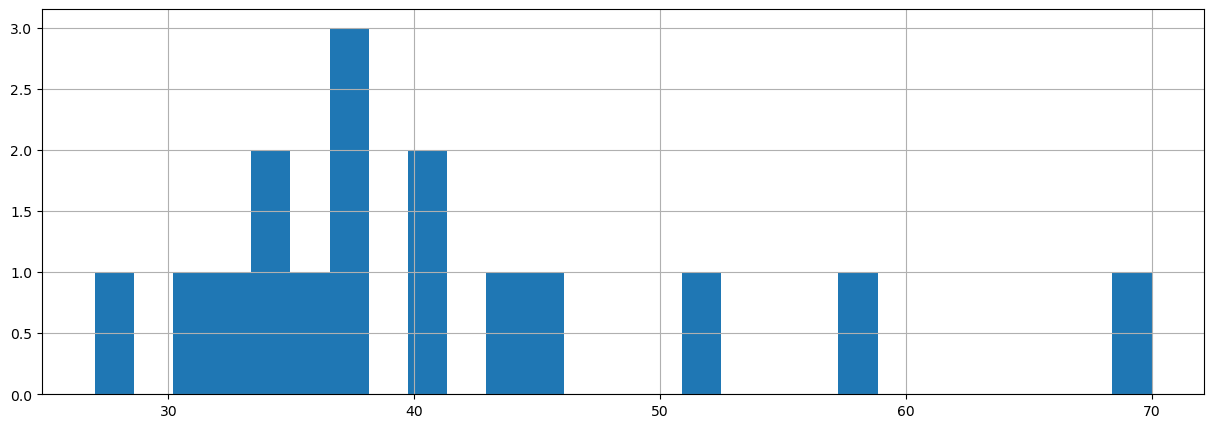

In [14]:
(games_df
 ['total']
 .hist(figsize=(15,5), bins=n_bins)
);

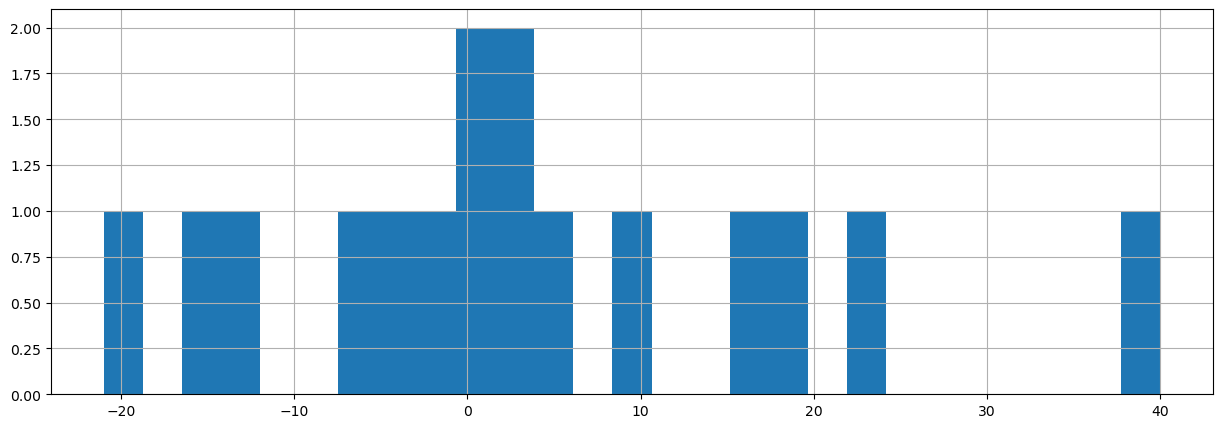

In [15]:
(games_df
 ['spread']
 .hist(figsize=(15,5), bins=n_bins)
);

In [16]:
# Need to figure out how to classify position depth --> May run into issues with injuries

In [17]:
import numpy as np
import scipy.stats as stats

import itertools

In [32]:

team_cores = {
    'NYG': [
        'Daniel Jones',
        'Saquon Barkley',
        # 'Isaiah Hodgins',
        # 'Darius Slayton'
        
    ],

    'SF': [
        'Brock Purdy',
        'Christian McCaffrey',
        'Deebo Samuel',
        # 'Brandon Aiyuk',
        # 'George Kittle'

    ]
}
team_dfs = {
    team: df.loc[(df['team'] == team) & (df['name'].isin(core)) & (df['fpts'] > 0.0)] 
    for team, core in team_cores.items()
}

In [33]:
# Get the games core players have played in together
# Example: If AJ Brown is missing, DeVonta Smith might have a much better game than usual and will skew results OR
# he might have a much worse game since a better corner is most likely guarding him
team_core_together_weeks = {
    team: tuple(team_df
                .groupby('week')
                ['week']
                .agg(['count'])
                .pipe(lambda df_: df_.loc[df_['count'] == len(team_cores[team])])
                .index
               )
    for team, team_df in team_dfs.items()
}

In [34]:
team_core_fpts = {
    team: {
        name: [ (team_df.loc[(team_df['name'] == name) & (team_df['week'] == week ), 'fpts'].item()) for week in team_core_together_weeks[team] ]
        for name in team_cores[team]
    }

    for team, team_df in team_dfs.items()
}

In [35]:
agg_stats = ['mean']

In [36]:
team_combo_corrs = {
    team: dict(sorted({
        combo: round(stats.pearsonr(core_fpts[combo[0]], core_fpts[combo[1]])[0],3)
        for combo in itertools.combinations(team_cores[team], 2)
    }.items(), key=lambda item: item[1], reverse=True))
    for team, core_fpts in team_core_fpts.items()
}

ValueError: x and y must have length at least 2.

In [37]:
team_combo_corrs['NYG']

NameError: name 'team_combo_corrs' is not defined

In [38]:
team_combo_corrs['SF']

NameError: name 'team_combo_corrs' is not defined

In [39]:
agg_stats = ['rush_yds', 'rush_td', 'rec_yds', 'rec_td']
teams = ['PIT', 'CLE']

In [40]:
agg_df = (df
          .groupby('opp')
          [agg_stats]
          .agg(['sum'])
          .reset_index()
          .set_axis(['opp'] + agg_stats, axis=1)
          .pipe(lambda df_: df_.loc[df_['opp'].isin(['NYG', 'SF'])])
          .set_index('opp')
          .assign(
              total_yds=lambda df_: df_.rush_yds + df_.rec_yds,
              total_td=lambda df_: df_.rush_td + df_.rec_td 
          )
         )
agg_df

,rush_yds,rush_td,rec_yds,rec_td,total_yds,total_td
opp,,,,,,
NYG,122,3,143,0,265,3
SF,41,0,232,1,273,1


In [69]:
# agg_df.sort_values([
#     'fpts',
#     # 'total_td',
#     # 'total_yds',
#     'rec',
#     # 'rush_td',
#     'rush_yds',
# ], ascending=False)